<p><font size="6"><b>Xarray</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2020*
>
> *© 2020, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import plotting_extent, reshape_as_image

## Introduction

By this moment you probably already know how to read data files with rasterio:

In [2]:
data_file = "./data/gent/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [3]:
with rasterio.open(data_file) as src:
    # extract data, metadata and extent into memory
    gent_profile = src.profile
    gent_data = src.read([1, 2, 3], out_dtype=float, masked=False)
    gent_ext = plotting_extent(src)

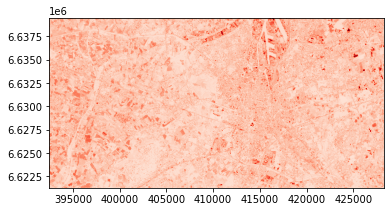

In [4]:
plt.imshow(gent_data[0, :, :], extent=gent_ext, cmap="Reds")

Rasterio...

__Benefits__
 - Direct link with Numpy data types
 - Rasterio supports important GIS transformations (clip, mask, warp, merge, transformation,...)
 - Only load a subset of a large data set into memory

__Drawbacks__:
 - Coordinate information is decoupled from the data itself (keep track and organize the extent and meta data) 
 - Make sure to keep track of what each dimension represents (y-first, as arrays are organized along rows first)
 - Functionality overlap with GDAL (and sometimes installation issues)

## Meet `xarray`

In [5]:
import xarray as xr

In [6]:
gent = xr.open_rasterio(data_file)
gent

<xarray.DataArray (band: 3, y: 317, x: 625)>
[594375 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:               (57.32777121388223, 0.0, 392465.9217302375, 0.0,...
    crs:                     +init=epsg:3857
    res:                     (57.32777121388223, 57.44833434997156)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

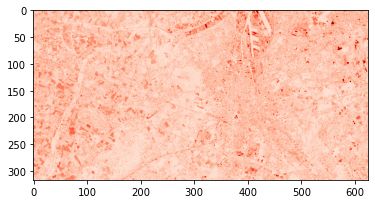

In [7]:
plt.imshow(gent.sel(band=1), cmap="Reds");

Xarray brings its own plotting methods, but relies on Matplotlib as well for the actual plotting:

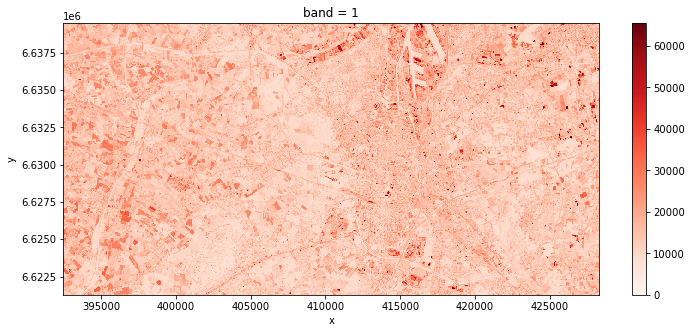

In [8]:
ax = gent.sel(band=1).plot.imshow(cmap="Reds", figsize=(12, 5))  # robust=True
# ax.axes.set_aspect('equal')

As a preview, plot the intersection of the data at x coordinate closest to 400000 for each band:

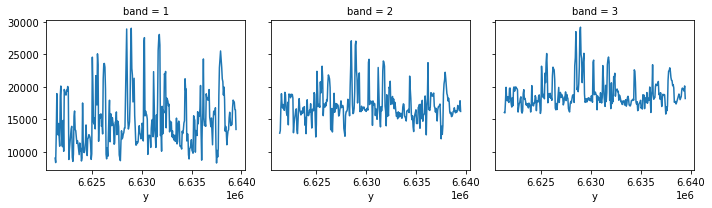

In [9]:
gent.sel(x=400_000, method='nearest').plot.line(col='band')

But first, let's have a look at the data again:

In [10]:
gent

<xarray.DataArray (band: 3, y: 317, x: 625)>
[594375 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:               (57.32777121388223, 0.0, 392465.9217302375, 0.0,...
    crs:                     +init=epsg:3857
    res:                     (57.32777121388223, 57.44833434997156)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

The output of xarray is a bit different to what we've previous seen. Let's go through the different elements:

- It is a `xarray.DataArray`, one of the main data types provided by xarray
- It has 3 __dimensions__:
    - `band`: 3 bands (RGB)
    - `y`: the y coordinates of the data set
    - `x`: the x coordinates of the data set
- Each of these dimensions are defined by a __coordinate__ (1D) array
- Other metadata provided by the `tiff` are stored in the __`Attributes`__

Looking to the data itself (click on the icons on the right), we can see this is still a Numpy array

In [11]:
#gent.values

In [12]:
gent = gent.assign_coords(band=("band", ["R", "G", "B"]))
gent

<xarray.DataArray (band: 3, y: 317, x: 625)>
[594375 values with dtype=uint16]
Coordinates:
  * band     (band) <U1 'R' 'G' 'B'
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:               (57.32777121388223, 0.0, 392465.9217302375, 0.0,...
    crs:                     +init=epsg:3857
    res:                     (57.32777121388223, 57.44833434997156)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

Hence, we can __name dimensions__ and also extract (slice) data using these names...

In [13]:
gent.sel(band='R')

<xarray.DataArray (y: 317, x: 625)>
[198125 values with dtype=uint16]
Coordinates:
    band     <U1 'R'
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:               (57.32777121388223, 0.0, 392465.9217302375, 0.0,...
    crs:                     +init=epsg:3857
    res:                     (57.32777121388223, 57.44833434997156)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

Using xarray:

- Data stored as a Numpy arrays
- Dimensions do have a name
- The coordinates of each of the dimensions can represent coordinates, categories, dates,... instead of just an index
   

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The [`xarray` package](xarray.pydata.org/en/stable/) introduces __labels__ in the form of dimensions, coordinates and attributes on top of raw numPy-like arrays. Xarray is inspired by and borrows heavily from Pandas.    

</div>

## Numpy with labels...

Recap the NDVI exercise of the Numpy notebook, using a stacked version of the 4th and 8th Sentinel band:

In [14]:
xr_array = xr.open_rasterio("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B0408.tiff")
xr_array

<xarray.DataArray (band: 2, y: 317, x: 625)>
[396250 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:      (57.32777121388223, 0.0, 392465.9217302375, 0.0, -57.4483...
    crs:            +init=epsg:3857
    res:            (57.32777121388223, 57.44833434997156)
    is_tiled:       0
    nodatavals:     (nan, nan)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    AREA_OR_POINT:  Area

In Numpy, we would do:

In [15]:
b48_bands = xr_array.values  # 0 is band 4 and 1 is band 8
b48_bands.shape

(2, 317, 625)

In [16]:
ndvi_np = (b48_bands[1] - b48_bands[0])/(b48_bands[0] + b48_bands[1]) # or was it b48_bands[0] -  b48_bands[1] ?

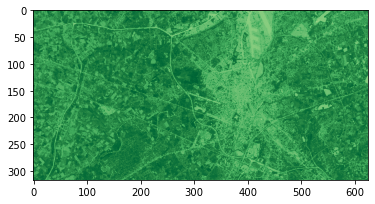

In [17]:
plt.imshow(ndvi_np, cmap="YlGn")

In __xarray__:

In [18]:
xr_array = xr_array.assign_coords(band=("band", ["b4", "b8"]))
xr_data = xr_array.to_dataset(dim="band")

In [19]:
ndvi_xr = (xr_data["b8"] - xr_data["b4"])/(xr_data["b8"] + xr_data["b4"])

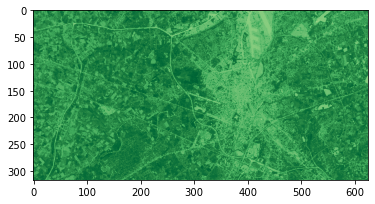

In [20]:
plt.imshow(ndvi_xr, cmap="YlGn")

The result is the same, but no more struggling on what index is representing which variable!

In [21]:
np.allclose(ndvi_xr.data, ndvi_np)

True

We can keep the result together with the other data variables by adding a new variable to the data, in a very similar way as we created a new column in Pandas:

In [22]:
xr_data["ndvi"] = ndvi_xr
xr_data

<xarray.Dataset>
Dimensions:  (x: 625, y: 317)
Coordinates:
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Data variables:
    b4       (y, x) float64 0.0782 0.0884 0.1751 ... 0.05769 0.0676 0.08299
    b8       (y, x) float64 0.2736 0.257 0.2479 0.2257 ... 0.3324 0.3388 0.3722
    ndvi     (y, x) float64 0.5554 0.4881 0.1721 0.153 ... 0.7042 0.6673 0.6353
Attributes:
    transform:      (57.32777121388223, 0.0, 392465.9217302375, 0.0, -57.4483...
    crs:            +init=epsg:3857
    res:            (57.32777121388223, 57.44833434997156)
    is_tiled:       0
    nodatavals:     (nan, nan)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    AREA_OR_POINT:  Area

You already encountered `xarray.DataArray`, but now we created a `xarray.Dataset`:

- A `xarray.Dataset` is the second main data type provided by xarray
- It has 2 __dimensions__:
    - `y`: the y coordinates of the data set
    - `x`: the x coordinates of the data set
- Each of these dimensions are defined by a __coordinate__ (1D) array
- It has 3 __Data variables__: `band_4`, `band_8` and `ndvi` that share the same coordinates
- Other metadata provided by the `tiff` are stored in the __`Attributes`__

Looking to the data itself (click on the icons on the right), we can see each of the _Data variables_ is a Numpy ndarrays:

In [23]:
type(xr_data["b4"].data)

numpy.ndarray

And also the coordinates that describe a dimension are Numpy ndarrays:

In [24]:
type(xr_data.coords["x"].values)

numpy.ndarray

__Selecting data__

Xarray’s labels make working with multidimensional data much easier:

In [25]:
xr_array = xr.open_rasterio("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B0408.tiff")

Rename the coordinates of the band dimension:

In [26]:
xr_array = xr_array.assign_coords(band=("band", ["b4", "b8"]))

We could use the Numpy style of data slicing:

In [27]:
xr_array[0]

<xarray.DataArray (y: 317, x: 625)>
[198125 values with dtype=float64]
Coordinates:
    band     <U2 'b4'
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:      (57.32777121388223, 0.0, 392465.9217302375, 0.0, -57.4483...
    crs:            +init=epsg:3857
    res:            (57.32777121388223, 57.44833434997156)
    is_tiled:       0
    nodatavals:     (nan, nan)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    AREA_OR_POINT:  Area

However, it is often much more powerful to use xarray’s `.sel()` method to use label-based indexing:

In [28]:
xr_array.sel(band="b4")

<xarray.DataArray (y: 317, x: 625)>
[198125 values with dtype=float64]
Coordinates:
    band     <U2 'b4'
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:      (57.32777121388223, 0.0, 392465.9217302375, 0.0, -57.4483...
    crs:            +init=epsg:3857
    res:            (57.32777121388223, 57.44833434997156)
    is_tiled:       0
    nodatavals:     (nan, nan)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    AREA_OR_POINT:  Area

We can select a specific set of coordinate values as a __list__ and take the value that is most near to the given value:

In [29]:
xr_array.sel(x=[406803, 410380, 413958], method="nearest")   # .sel(band="b4").plot.line(hue="x");

<xarray.DataArray (band: 2, y: 317, x: 3)>
array([[[0.059602, 0.081895, 0.164004],
        [0.059998, 0.065293, 0.1355  ],
        ...,
        [0.136004, 0.058305, 0.108705],
        [0.067506, 0.082795, 0.092805]],

       [[0.249195, 0.327794, 0.204807],
        [0.2374  , 0.348608, 0.167697],
        ...,
        [0.203403, 0.2374  , 0.147601],
        [0.2112  , 0.357198, 0.132799]]])
Coordinates:
  * band     (band) <U2 'b4' 'b8'
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 4.068e+05 4.104e+05 4.139e+05
Attributes:
    transform:      (57.32777121388223, 0.0, 392465.9217302375, 0.0, -57.4483...
    crs:            +init=epsg:3857
    res:            (57.32777121388223, 57.44833434997156)
    is_tiled:       0
    nodatavals:     (nan, nan)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    AREA_OR_POINT:  Area

Sometimes, a specific range is required. The `.sel()` method also supports __slicing__, so we can select band 4 and slice a subset of the data along the x direction:

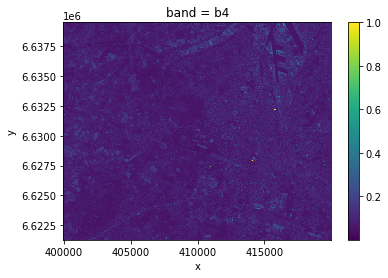

In [30]:
xr_array.sel(x=slice(400_000, 420_000), band="b4").plot.imshow()

__Note__ Switch in between `Array` and `Datasets` as you like, it won't hurt your computer memory:

In [31]:
xr_data = xr_array.to_dataset(dim="band")

In [32]:
#xr_data.to_array()    # dim="band"

### Reduction

Just like in numpy, we can reduce xarray DataArrays along any number of axes:

In [33]:
xr_data["b4"].mean(axis=0).dims

('x',)

In [34]:
xr_data["b4"].mean(axis=1).dims

('y',)

But we have __dimensions with labels__, so rather than performing reductions on axes (as in Numpy), we can perform them on __dimensions__. This turns out to be a huge convenience:

In [35]:
xr_data["b4"].mean(dim="x").dims

('y',)

Calculate minimum or quantile values for each of the bands separately:

In [36]:
xr_array.min(dim=["x", "y"])

<xarray.DataArray (band: 2)>
array([1.e-06, 1.e-06])
Coordinates:
  * band     (band) <U2 'b4' 'b8'

In [37]:
xr_array.quantile([0.1, 0.5, 0.9], dim=["x", "y"])

<xarray.DataArray (quantile: 3, band: 2)>
array([[0.05749599, 0.13560693],
       [0.08310063, 0.23059434],
       [0.13060197, 0.32539864]])
Coordinates:
  * band      (band) <U2 'b4' 'b8'
  * quantile  (quantile) float64 0.1 0.5 0.9

### Element-wise computation

Xarray DataArrays and Datasets work seamlessly with arithmetic operators and numpy array functions.

In [38]:
xr_data["b4"] /10.

<xarray.DataArray 'b4' (y: 317, x: 625)>
array([[0.00782025, 0.00883955, 0.01750973, ..., 0.01033951, 0.01040055,
        0.00863966],
       [0.01022049, 0.00758984, 0.00854963, ..., 0.00731975, 0.00657053,
        0.0065507 ],
       [0.01011063, 0.00800031, 0.0076997 , ..., 0.00688029, 0.00733043,
        0.00704967],
       ...,
       [0.0072694 , 0.00742046, 0.0068101 , ..., 0.01409018, 0.01008011,
        0.00682994],
       [0.00702983, 0.00695048, 0.00672007, ..., 0.00733959, 0.00890059,
        0.00599069],
       [0.00706035, 0.00747997, 0.00724041, ..., 0.00576944, 0.00675975,
        0.00829938]])
Coordinates:
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05

In [39]:
np.log(xr_data["b8"])

<xarray.DataArray 'b8' (y: 317, x: 625)>
array([[-1.29610906, -1.35870858, -1.39473763, ..., -1.25985297,
        -1.4056924 , -1.4605655 ],
       [-1.36376827, -1.4610258 , -1.34825398, ..., -1.36609837,
        -1.49923676, -1.46531016],
       [-1.48458449, -1.41714613, -1.31713162, ..., -1.30271196,
        -1.2687131 , -1.17216053],
       ...,
       [-1.31082926, -1.37276006, -1.23101297, ..., -1.40407569,
        -1.23200636, -1.17442956],
       [-1.265138  , -1.22928996, -1.22554093, ..., -1.5418142 ,
        -1.33866383, -0.96811823],
       [-1.24305213, -1.39393775, -1.33977018, ..., -1.1014086 ,
        -1.08235694, -0.98832914]])
Coordinates:
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05

As we seen in the example of the NDVI, we can combine multiple xarray datasets in arithemetic operations:

In [40]:
xr_data["b8"] + xr_data["b4"]

<xarray.DataArray (y: 317, x: 625)>
array([[0.35179675, 0.34538796, 0.42299535, ..., 0.38709087, 0.34920272,
        0.31850156],
       [0.35790036, 0.30789654, 0.34518959, ..., 0.32829786, 0.28900587,
        0.29651331],
       [0.32770275, 0.32240787, 0.34489967, ..., 0.34059663, 0.3544976 ,
        0.38019379],
       ...,
       [0.34229038, 0.3276112 , 0.36009766, ..., 0.38649577, 0.39250782,
        0.37729458],
       [0.35249866, 0.36200504, 0.36079957, ..., 0.28738842, 0.35120165,
        0.43970397],
       [0.35910582, 0.32289616, 0.33430991, ..., 0.39009689, 0.40639353,
        0.45519188]])
Coordinates:
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05

### Broadcasting

Perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting:

In [41]:
xr_data.x.shape, xr_data["b8"].shape

((625,), (317, 625))

In [42]:
xr_data["b8"] + xr_data.x  # Note, this calculaton does not make much sense, but illustrates broadcasting

<xarray.DataArray (y: 317, x: 625)>
array([[392494.85921011, 392552.17037951, 392609.48905634, ...,
        428152.74300661, 428210.03227932, 428267.34695829],
       [392494.84131127, 392552.14538523, 392609.50085157, ...,
        428152.71441121, 428210.01038262, 428267.34585964],
       [392494.81221232, 392552.15579188, 392609.50906092, ...,
        428152.73110458, 428210.06827535, 428267.42455042],
       ...,
       [392494.85521224, 392552.16679363, 392609.53315492, ...,
        428152.70490484, 428210.07878881, 428267.4238485 ],
       [392494.8678162 , 392552.20588725, 392609.53475711, ...,
        428152.6733034 , 428210.04927787, 428267.49465036],
       [392494.87411817, 392552.1614835 , 392609.50306412, ...,
        428152.79171341, 428210.12587816, 428267.48705137]])
Coordinates:
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05

## Plotting

Similar to Pandas, there is a `plot` method, which can be used for different plot types:

In [43]:
xr_array = xr.open_rasterio("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B0408.tiff")
xr_array = xr_array.assign_coords(band=("band", ["b4", "b8"]))

It supports both 2 dimensional (e.g. line) as 3 (e.g. imshow, pcolormesh) dimensional plots. When just using `plot`, xarray will do a _best guess_ on how to plot the data. However being explicit `plot.line`, `plot.imshow`, `plot.pcolormesh`, `plot.scatter`,...  gives you more control.

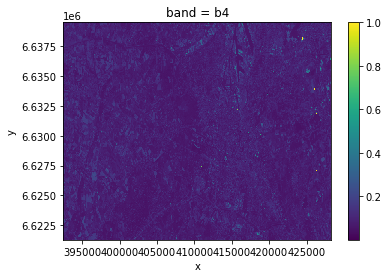

In [44]:
xr_array.sel(band="b4").plot();  # add .line() -> ValueError: For 2D inputs, please specify either hue, x or y.

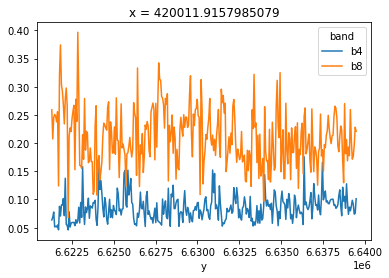

In [45]:
xr_array.sel(x=420000, method="nearest").plot.line(hue="band");

`facetting` splits the data in subplots according to a dimension, e.g. `band`

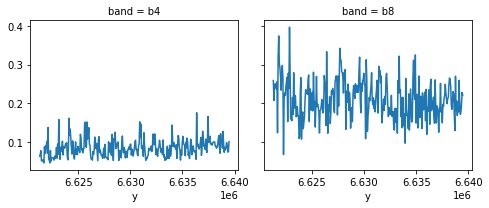

In [46]:
xr_array.sel(x=420000, method="nearest").plot.line(col="band");  # row="band"

Use the `robust` option when there is a lack of visual difference. This will use the 2nd and 98th percentiles of the data to compute the color limits. The arrows on the color bar indicate that the colors include data points outside the bounds.

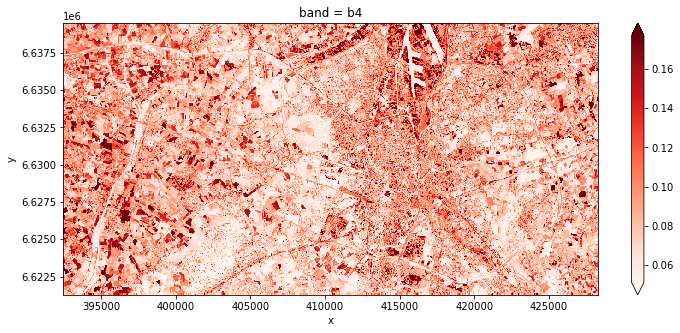

In [47]:
ax = xr_array.sel(band="b4").plot(cmap="Reds", robust=True, figsize=(12, 5))
ax.axes.set_aspect('equal')

Compare data variables within a `xarray Dataset`:

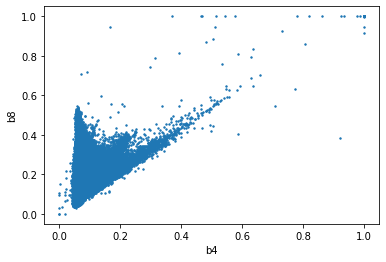

In [48]:
xr_data = xr_array.to_dataset(dim="band")
xr_data.plot.scatter(x="b4", y="b8", s=2)

Calculating and plotting the NDVI in three classes illustrates the options of the `imshow` method:

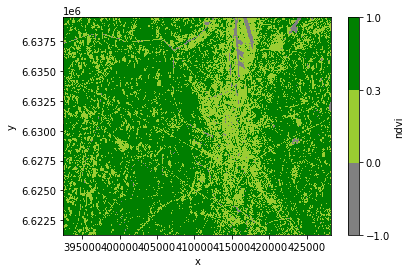

In [49]:
xr_data["ndvi"] = (xr_data["b8"] - xr_data["b4"])/(xr_data["b8"] + xr_data["b4"])
xr_data["ndvi"].plot.imshow(levels=[-1, 0, 0.3, 1.], colors=["gray", "yellowgreen", "g"])

# Let's practice!

The data set for the following exercises is from [Argo floats](https://argo.ucsd.edu/), an international collaboration that collects high-quality temperature and salinity profiles from the upper 2000m of the ice-free global ocean and currents from intermediate depths.

These data do not represent full coverage image data (like remote sensing images), but measurements of salinity and temperature as a function of water `level` (related to the pressure). Each measurements happens at a given `date` on a given location (`lon`/`lat`).

In [50]:
import xarray as xr
argo = xr.load_dataset("./data/argo_float.nc")

In [51]:
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int32 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

The bold font (or * symbol in plain text output version) in the coordinate representation above indicates that x and y are 'dimension coordinates' (they describe the coordinates associated with data variable axes) while band is a 'non-dimension coordinates'. We can make any variable a non-dimension coordinate.

Let's plot the coordinates of the available measurements and add a background map using [contextly](https://contextily.readthedocs.io/en/latest/index.html):

<div class="alert alert-success">

**EXERCISE**:

Add a new variable to the `argo` data set, called `temperature_kelvin`, by converting the temperature to Kelvin. 
    
Degrees Kelvin = degrees celsius + 273.
   
<details>
    
<summary>Hints</summary>

* Remember that xarray works as Numpy and relies on the same broadcasting rules.

</details>    
    
</div>

In [52]:
argo["temperature_kelvin"] = argo["temperature"] + 273.15

<div class="alert alert-success">

**EXERCISE**:

The water level classes define different water depths. The pressure is a proxy for the water depth. Verify the relationship between the pressure and the level using a scatter plot. Does a larger value for the level represent deeper water depths or not?
    
<details><summary>Hints</summary>
    
* If you get the error `ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)`, read the message and do what it says.

</details>    
    
</div>

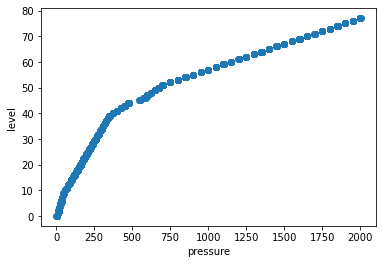

In [53]:
argo.plot.scatter(x="pressure", y="level")

<div class="alert alert-success">

**EXERCISE**:

Assume that buoyancy is defined by the following formula:
    
$$g \cdot ( 2\times 10^{-4} \cdot T - 7\times 10^{-4} \cdot P )$$

With:
- $g$ = 9.8
- $T$ = temperature
- $P$ = pressure

Calculate the buoyancy and add it as a new variable `buoyancy` to the `argo` data set. 

Make a 2D (image) plot with the x-axis the date, the y-axis the water level and the color intensity the buoyancy. As the level represents the depth of the water, it makes more sense to have 0 (surface) at the top of the y-axis: switch the y-axis direction.
    
<details><summary>Hints</summary>

* Remember that xarray works as Numpy and relies on the same broadcasting rules.
* The `imshow` method does not work on irregular intervals. Matplotlib and xarray also have `pcolormesh`.    
* Look for options [in the xarray documentation](http://xarray.pydata.org/en/stable/plotting.html#other-axes-kwargs) to control the axis direction. (The `ax.invert_yaxis()` Matplotlib function is not supported for pcolormesh)
    
</details>    
    
</div>

In [54]:
argo["buoyancy"] = 9.8 * (2e-4 * argo["temperature"] - 7e-4 * argo["salinity"])

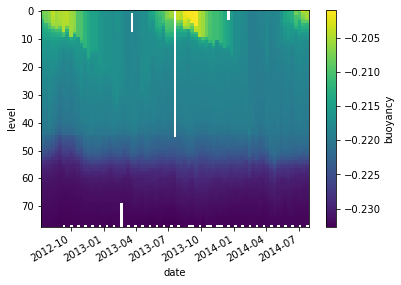

In [55]:
argo["buoyancy"].plot(yincrease=False)  # xarray decides the plot type when no specific method is used

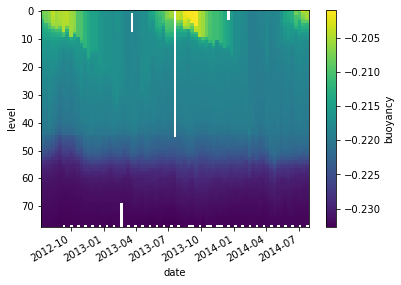

In [56]:
# More explicit version defining the x and y axis
argo["buoyancy"].plot.pcolormesh(x="date", y="level", yincrease=False)  # pcolormesh instead of imshow

<div class="alert alert-success">

**EXERCISE**:

Make a line plot of the salinity as a function of time at level 10
   
<details><summary>Hints</summary>

Break it down into different steps and chain the individual steps:
    
* From the argo data set, select the variable `salinity`. This is similar to selecting a column in Pandas.
* Next, use the `sel` method to select the `level=10`
* Next, use the `plot.line()` method.

</details>    
    
</div>

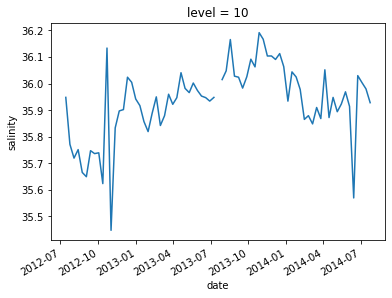

In [57]:
argo["salinity"].sel(level=10).plot.line()

<div class="alert alert-success">

**EXERCISE**:

- Make a line plot of the temperature as a function of time for the levels 10, 20 and 30 at the same graph 
- Make a second line plot with each of the 3 levels (10, 20, 30) in a different subplot. 
   
<details><summary>Hints</summary>

Break it down into different steps and chain these individual steps:
    
* From the argo data set, select the variable `temperature`. This is similar to selecting a column in Pandas.
* Next, use the `sel` method to select the levels 10, 20 and 30.
* Next, use the `plot.line()` method, but make sure the `hue` changes for each level
    
For the subplots, check the [facetting documentation](http://xarray.pydata.org/en/stable/plotting.html#faceting) of xarray. 

</details>    
    
</div>

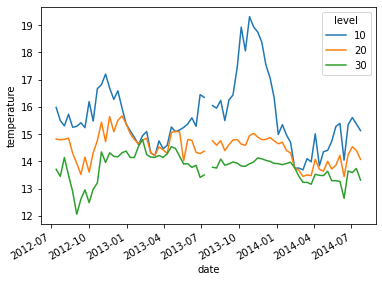

In [58]:
argo["temperature"].sel(level=[10, 20, 30]).plot.line(hue="level");

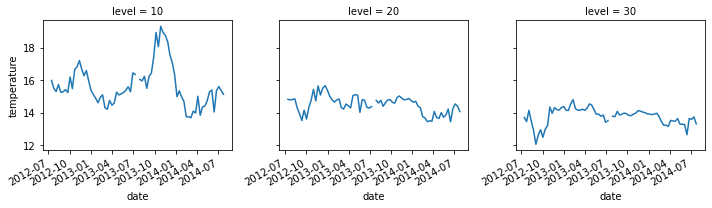

In [59]:
argo["temperature"].sel(level=[10, 20, 30]).plot.line(col="level");

<div class="alert alert-success">

**EXERCISE**:

You wonder how the temperature evolves with increasing latitude and what the effect is of the depth (level):

- Create a scatter plot of the `level` as a function of the `temperature` colored by the `latitude`. 
    
- As a further exploration step, pick a subset of levels 1, 10, 25, and 50 and create a second scatter plot with in the x-axis the latitude of the measurement and in the y-axis the temperature. To compare the effect of the different levels, give each level a separate subplot next to each other.
   
<details><summary>Hints</summary>

* In a scatter plot, the color or hue can be linked to a variable.
* From the argo data set, use the `sel` method to select the levels 1, 10, 25, and 50.
* For the second scatter plot, but make sure the `col` changes for each `level` and define which variables need to go to which axis.

</details>    
    
</div>

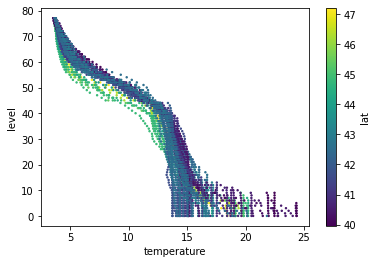

In [60]:
argo.plot.scatter(x="temperature", y="level", hue="lat", s=2)

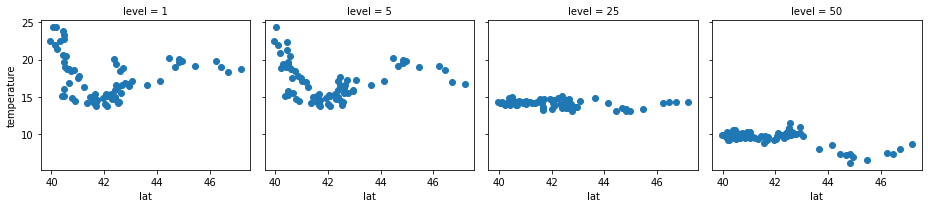

In [61]:
argo.sel(level=[1, 5, 25, 50]).plot.scatter(x="lat", y="temperature", col="level")

<div class="alert alert-success">

**EXERCISE**:

Make an image plot of the temperature as a function of time. Divide the colormap in 3 discrete categories:
    
* x < 5
* 5 < x < 15
* x > 15
    
Choose a custom colormap and adjust the label of the colorbar to `'Temperature (°C)'`
   
<details>
    
<summary>Hints</summary>

- Check the help of the `plot` function or the [xarray documentation](http://xarray.pydata.org/en/stable/plotting.html#discrete-colormaps) on discrete colormaps.
- Adjustments to the colorbar settings can be defined with the `cbar_kwargs` as a dict. Adjust the `label` of the colorbar.    

</details>    
    
</div>

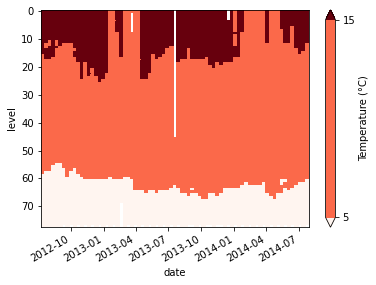

In [62]:
argo.temperature.plot.pcolormesh(yincrease=False, 
                                 cbar_kwargs={'label': 'Temperature (°C)'},
                                 cmap='Reds',
                                 levels=[5, 15]
                                );

<div class="alert alert-success">

**EXERCISE**:

Calculate the average salinity and temperature as a function of level over the measurements taken between 2012-10-01 and 2012-12-01. 

Make a separate line plot for each of them. Define the figure and 2 subplots first with Matplotlib. 
    
<details><summary>Hints</summary>

* xarray supports to query dates using a string representation.
* Use the `slice` operator within the `sel` to select a range of the data.
* Whereas in Numpy we used `axis` in reduction functions, xarray uses the `dim` name.
* Also for line plots you can define which dimension should be on the x-axis and which on the y-axis by providing the name.  
* Use `fig, (ax0, ax1) = plt.subplots(1, 2)` to create subplots.
</details>    
    
</div>

In [63]:
subset_mean = argo.sel(date=slice('2012-10-01', '2012-12-01')).mean(dim="date")

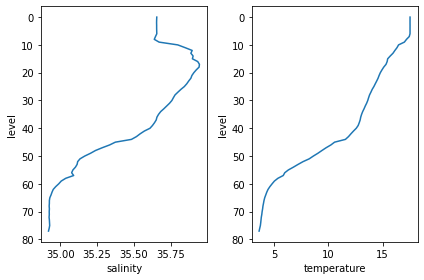

In [64]:
fig, (ax0, ax1) = plt.subplots(1, 2)
subset_mean["salinity"].plot.line(y="level", yincrease=False, ax=ax0)
subset_mean["temperature"].plot.line(y="level", yincrease=False, ax=ax1)
plt.tight_layout()

## Pandas for multiple dimensions...

In [65]:
argo = xr.load_dataset("./data/argo_float.nc")

If we are interested in the _average over time_ for each of the levels, we can use a reducton function to get the averages of each of the variables at the same time:

In [66]:
argo.mean(dim=["date"])

<xarray.Dataset>
Dimensions:      (level: 78)
Coordinates:
  * level        (level) int32 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
Data variables:
    salinity     (level) float64 35.91 35.9 35.9 35.9 ... 34.94 34.94 34.93
    temperature  (level) float64 17.6 17.57 17.51 17.42 ... 3.789 3.73 3.662
    pressure     (level) float64 6.435 10.57 15.54 ... 1.95e+03 1.999e+03

But if we wanted the _average for each month of the year_ per level, we would first have to __split__ the data set in a group for each month of the year, __apply__ the average function on each of the months and __combine__ the data again. 

We already learned about the [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) approach when using Pandas. The syntax of Xarray’s groupby is almost identical to Pandas! 

First, extract the month of the year (1-> 12) from each of the date coordinates:

In [67]:
argo.date.dt.month  # The coordinates is a Pandas datetime index

<xarray.DataArray 'month' (date: 75)>
array([ 7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 11, 11, 12, 12, 12,
       12,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,
        6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
       12, 12, 12,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7])
Coordinates:
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

We can use these arrays in a groupby operation:

In [68]:
argo.groupby(argo.date.dt.month)

DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Xarray also offers a more concise syntax when the variable you're grouping on is already present in the dataset. This is identical to the previous line:

In [69]:
argo.groupby("date.month")

DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Next, we apply an aggregation function _for each of the months_ over the `date` dimension in order to end up with: _for each month of the year, the average (over time) for each of the levels_:

In [70]:
argo.groupby("date.month").mean(dim="date")        #["temperature"].sel(level=1).to_series().plot.barh()

<xarray.Dataset>
Dimensions:      (level: 78, month: 12)
Coordinates:
  * level        (level) int32 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    salinity     (month, level) float64 35.95 35.95 35.95 ... 34.94 34.94 34.93
    temperature  (month, level) float64 15.06 15.06 15.06 ... 3.779 3.733 3.663
    pressure     (month, level) float64 6.6 10.42 15.32 ... 1.95e+03 1.998e+03

Another (alike) operation - specifically for time series data - is to `resample` the data to another time-aggregation. For example, resample to monthly (`1M`) or yearly (`1Y`) median values:

In [71]:
argo.resample(date="1M").median()  # 1Y

<xarray.Dataset>
Dimensions:      (date: 25, level: 78)
Coordinates:
  * date         (date) datetime64[ns] 2012-07-31 2012-08-31 ... 2014-07-31
  * level        (level) int32 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
Data variables:
    salinity     (date, level) float64 35.58 35.58 35.6 ... 34.94 34.94 34.94
    temperature  (date, level) float64 18.71 18.57 18.37 ... 3.811 3.754 3.714
    pressure     (date, level) float64 6.45 10.65 14.9 ... 1.95e+03 2e+03

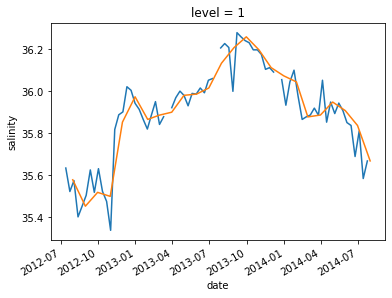

In [72]:
argo["salinity"].sel(level=1).plot.line(x="date");
argo["salinity"].resample(date="1M").median().sel(level=1).plot.line(x="date");  # 1Y

A similar, but different functionality is `rolling` to calculate rolling window aggregates:

In [73]:
argo.rolling(level=10, center=True).std()

/home/joris/miniconda3/envs/DS-geospatial-test/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joris/miniconda3/envs/DS-geospatial-test/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joris/miniconda3/envs/DS-geospatial-test/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int32 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 nan nan nan nan nan ... nan nan nan nan
    temperature  (level, date) float64 nan nan nan nan nan ... nan nan nan nan
    pressure     (level, date) float64 nan nan nan nan nan ... nan nan nan nan

No handles with labels found to put in legend.


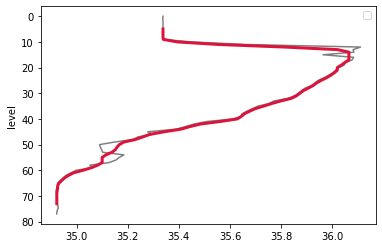

In [74]:
argo["salinity"].sel(date='2012-10-31').plot.line(y="level", yincrease=False, color="grey");
argo["salinity"].sel(date='2012-10-31').rolling(level=10, center=True).median().plot.line(y="level", yincrease=False, linewidth=3, color="crimson");
plt.legend(), plt.title("");

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The [xarray `groupby`](http://xarray.pydata.org/en/stable/groupby.html) with the same syntax as Pandas implements the __split-apply-combine__ strategy. Also [`resample`](http://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations) and [`rolling`](http://xarray.pydata.org/en/stable/computation.html?highlight=rolling#rolling-window-operations) are available in xarray.
    
__Note:__ Xarray adds a [`groupby_bins`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.groupby_bins.html#xarray.Dataset.groupby_bins) convenience function for binned groups (instead of each value).

</div>

---------------

__Note:__ Values are only read from disk when needed. For example, the following statement only reads the coordinate information and the metadata. The data itself is not yet loaded:

In [75]:
gent = xr.open_rasterio(data_file)
gent

<xarray.DataArray (band: 3, y: 317, x: 625)>
[594375 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:               (57.32777121388223, 0.0, 392465.9217302375, 0.0,...
    crs:                     +init=epsg:3857
    res:                     (57.32777121388223, 57.44833434997156)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

`load()` will explicitly load the data into memory:

In [76]:
xr.open_rasterio(data_file).load()

<xarray.DataArray (band: 3, y: 317, x: 625)>
array([[[12812, 14483, 28688, ..., 16941, 17039, 14156],
        [16744, 12435, 14008, ..., 11993, 10764, 10731],
        [16564, 13107, 12615, ..., 11272, 12009, 11551],
        ...,
        [11911, 12157, 11157, ..., 23085, 16515, 11190],
        [11518, 11387, 11010, ..., 12026, 14582,  9814],
        [11567, 12255, 11862, ...,  9453, 11075, 13599]],

       [[15663, 16777, 27115, ..., 17826, 18186, 16482],
        [16040, 15188, 16433, ..., 15663, 14221, 13779],
        [16400, 15548, 15221, ..., 14631, 15778, 15974],
        ...,
        [15319, 15450, 15188, ..., 21610, 18841, 15810],
        [15401, 15532, 15401, ..., 14516, 16859, 15859],
        [15696, 15483, 15352, ..., 13844, 15810, 17334]],

       [[17776, 18645, 28475, ..., 19153, 19497, 18235],
        [18563, 17842, 18596, ..., 17613, 17023, 17154],
        [18628, 17563, 18088, ..., 17400, 18137, 17776],
        ...,
        [17645, 17744, 17432, ..., 22380, 20152, 17727],
        [17580, 17383, 17252, ..., 17776, 18284, 17350],
        [17891, 17678, 17662, ..., 16335, 17301, 18415]]], dtype=uint16)
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 6.639e+06 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
  * x        (x) float64 3.925e+05 3.926e+05 3.926e+05 ... 4.282e+05 4.283e+05
Attributes:
    transform:               (57.32777121388223, 0.0, 392465.9217302375, 0.0,...
    crs:                     +init=epsg:3857
    res:                     (57.32777121388223, 57.44833434997156)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

Acknowledgements and great thanks to https://earth-env-data-science.github.io for the inspiration, data and examples.